# Black Friday--Cluster

## dataset description

"Dataset of 550 000 observations about the black Friday in a retail store, it contains different kinds of variables either numerical or categorical. It contains missing values."

## raw data


In [102]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [5]:
df_allData=pd.read_csv('BlackFriday.csv')
print(df_allData.sample(n=5))

        User_ID Product_ID Gender    Age  Occupation City_Category  \
324155  1001891  P00345742      M  46-50           1             C   
384692  1005193  P00084842      M  36-45          12             B   
34262   1005282  P00183642      F  18-25           4             B   
328396  1002590  P00128342      M  18-25           4             A   
270293  1005650  P00367042      F  36-45          12             B   

       Stay_In_Current_City_Years  Marital_Status  Product_Category_1  \
324155                          3               1                   1   
384692                          2               1                   8   
34262                           1               1                   4   
328396                          0               0                   5   
270293                          2               1                   8   

        Product_Category_2  Product_Category_3  Purchase  
324155                 2.0                15.0     11700  
384692                

raw data has 12 columns and there are a lot of missing values in "Product_Category_2" and "Product_Category_3". Which means some of the product whould just have one category.

## data pre-processing


In our opinion, we think our model would do cluster on different people, so our key is people.

But the dataset includes different records of one-single people. So at the beginning we use gruopby to get each people's whole records. 

Then we try to get the mode of each one's "Product_Category_1" to represent the main product category and get the mean of one people's whole "Purchase" as a feature of "average purchase". (We are not sure weather this is a good way buy we have to do this because we cannot keep all the data to train)

What's more, we change the "Gender" attribute to 0-1 attribute.

In [13]:
groupByUserData=df_allData.groupby(['User_ID'])

times=df_allData['User_ID'].value_counts()
times=times.sort_index()

#get the mean
meanData=groupByUserData.mean()

#get the mode
modeData=groupByUserData.agg(lambda x: stats.mode(x)[0][0])

mean_mode_data={'Gender':modeData['Gender'],'Occupation':modeData['Occupation'],'Age':modeData['Age'],'City_Category':modeData['City_Category'],'Marital_Status':modeData['Marital_Status'],'Product_CateGory_1':modeData['Product_Category_1'],'Stay_In_Current_City_Years':modeData['Stay_In_Current_City_Years']}
mean_mode_data=pd.DataFrame(mean_mode_data)
mean_mode_data['times']=times
mean_mode_data['Gender_M']=pd.get_dummies(mean_mode_data['Gender'])['M']
mean_mode_data=mean_mode_data.drop(['Gender'],axis=1)
mean_mode_data['Purchase']=meanData['Purchase']

print (mean_mode_data.sample(5))

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


         Occupation    Age City_Category  Marital_Status  Product_CateGory_1  \
User_ID                                                                        
1004956          15  36-45             B               1                   8   
1000839           0  26-35             A               0                   8   
1003510           4  18-25             B               1                   5   
1003016          12  18-25             A               0                   1   
1005555          10   0-17             B               0                   1   

        Stay_In_Current_City_Years  times  Gender_M      Purchase  
User_ID                                                            
1004956                          1    120         1   9324.600000  
1000839                          2    435         1  10761.390805  
1003510                          1     32         0   9913.406250  
1003016                          1     18         1  11067.111111  
1005555                        

## feature extraction

This is the hardest part of our cluster project.

There are two key problems we have to face:

##### 1. **how to handle the discrete attributes?**
    
    There are a lot of disordered discrete attributes in our data, likes "Marital_Status", "Gender" and "Product_Category_1", we cannot just simplely calculate their euclidean distance.

##### 2. **how to evaluate our feature extraction performance?**

    Since we have so many choices of extracting the features and we do not know how to assign the weights on these feautres and this is a cluster problem, we had not a clearly mind of have to evaluate our work when we doing the feature extraction. And it is unrealistic to try all the choices and train them then evaluate the final models. The best solution is that we can find some explainable output of our feature extraction.
    
#### deal with discrete attributes

To solve the key problems 1, we came up with ideas.

1. do one-hot encoding on the discrete attributes

1. use k-modes or k-prototype model

1. drop those discrete attributes

But their would raise some new problems if we use these solutions:

    one-hot encoding would make the features very sparse.
    
    It is not easy to combine the VDM distance and Minkowski distance together.
    
    Some discrete features may be very important like occupation but it would have a lot of possible value.
    
#### deal with evaluation

We do not find a good way to solve this problem, we just living with it, but we still did some tries. Likes using the average purchase to evaluate the cluster output. And we use Calinski-Harabasz score and Value Difference Metrix to evalue our final clusters.

## data pre-processing before training

Since we have features of different units, we must do the data standardization and assign different weights to different features.

We choose min-max standardization and assign the weights by feeling.

## specific approach 1 by Chaoji: k-modes

I try to use the k-modes only on the categorical values to train a model, then use one-hot encoidng data to calculate the jaccard distance and euclidean distance.

In [15]:
from kmodes.kmodes import KModes

In [32]:
X=pd.DataFrame({'Gender':modeData['Gender'],'Occupation':modeData['Occupation'],'Age':modeData['Age'],'City_Category':modeData['City_Category'],'Marital_Status':modeData['Marital_Status'],'Product_CateGory_1':modeData['Product_Category_1'],"Stay_In_Current_City_Years":modeData["Stay_In_Current_City_Years"]})

one_hot_city=pd.get_dummies(mean_mode_data['City_Category'])
one_hot_age=pd.get_dummies(mean_mode_data['Age'])
one_hot_occupation=pd.get_dummies(mean_mode_data['Occupation'])
one_hot_years=pd.get_dummies(mean_mode_data['Stay_In_Current_City_Years'])
one_hot_product=pd.get_dummies(mean_mode_data['Product_CateGory_1'])
XX=pd.concat([one_hot_age,one_hot_city,one_hot_occupation,one_hot_years,one_hot_product],axis=1)
XX['Gender_M']=mean_mode_data['Gender_M']
XX['Marital_Status']=mean_mode_data['Marital_Status']

print ("categorical data:")
print(X.sample(2))
print("one-hot encoding data:")
print(XX.sample(2))


categorical data:
        Gender  Occupation    Age City_Category  Marital_Status  \
User_ID                                                           
1004491      M           4  18-25             C               0   
1002099      F           0  18-25             B               0   

         Product_CateGory_1 Stay_In_Current_City_Years  
User_ID                                                 
1004491                   1                          3  
1002099                   1                          1  
one-hot encoding data:
         0-17  18-25  26-35  36-45  46-50  51-55  55+  A  B  C  \
User_ID                                                          
1005763     0      0      1      0      0      0    0  1  0  0   
1000750     0      0      0      1      0      0    0  0  1  0   

              ...        8  10  11  12  13  15  16  18  Gender_M  \
User_ID       ...                                                  
1005763       ...        0   0   0   0   0   0   0   0       

In [98]:
from sklearn.metrics import jaccard_similarity_score

jcArr=[]
for i in range(2,10):
    km=KModes(n_clusters=i)
    y=km.fit_predict(X)
    tempArr=[]
    for j in range(i):
        #print(sum(y==j))
        #print(XX[y==j].mode())
        jcscore=[]
        for k in XX[y==j].T:
            try:
                jcscore.append(jaccard_similarity_score(XX.loc[k],XX[y==j].mode().T[0]))
            except:
                #print(XX.loc[k].T)
                print(XX[y==j].mode())
                hhh=XX[y==j].mode()
                #print(k)
                break;
        #print(np.mean(jcscore))
        tempArr.append(np.mean(jcscore))
    print("n_cluster =",i,":",np.mean(tempArr))
    jcArr.append(np.mean(tempArr))



n_cluster = 2 : 0.899945735205008
n_cluster = 3 : 0.9052649771127564
n_cluster = 4 : 0.9076230851962331
n_cluster = 5 : 0.9091319942547468
n_cluster = 6 : 0.9110580817498755
n_cluster = 7 : 0.9134560686831265
n_cluster = 8 : 0.9159545712371329
n_cluster = 9 : 0.9175658366310118


In [99]:
ecArr=[]
for i in range(2,10):
    km=KModes(n_clusters=i)
    y=km.fit_predict(X)
    tempArr=[]
    for j in range(i):
        #print(sum(y==j))
        #print(XX[y==j].mode())
        ecscore=[]
        for k in XX[y==j].T:
            if(k):
                ecscore.append(np.linalg.norm(np.array(XX.loc[k])-np.array(XX[y==j].mode().T[0])))
        #print(np.mean(ecscore))
        tempArr.append(np.mean(ecscore))
    print("n_cluster =",i,":",np.mean(tempArr))
    ecArr.append(np.mean(tempArr))



n_cluster = 2 : 2.2859319572501864
n_cluster = 3 : 2.2219032914109973
n_cluster = 4 : 2.1924274314853203
n_cluster = 5 : 2.1742366639489976
n_cluster = 6 : 2.15022007309971
n_cluster = 7 : 2.1175923149028657
n_cluster = 8 : 2.082098902497027
n_cluster = 9 : 2.0586750350554346


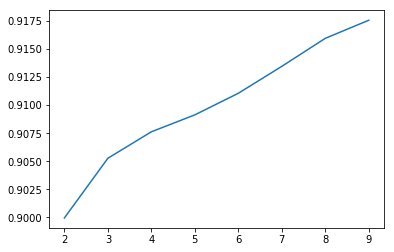

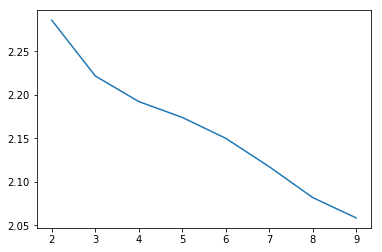

In [104]:
ecArr=[2.2859319572501864,2.2219032914109973,2.1924274314853203,2.1742366639489976,2.15022007309971,2.1175923149028657,2.082098902497027,2.0586750350554346]
plt.plot(list(range(2,10)),jcArr)
plt.figure()
plt.plot(list(range(2,10)),ecArr)




### further improvement

## specific approach 2:

## specific approach 3: